#<h1><center>  Tarea 5 EL7008 </center></h1>
## <h1><center>  Clasificación de objetos usando CNNs </center></h1>

**Integrante**: 

Diego Pincheira

**Profesor**: 

Javier Ruiz del Solar

**Auxiliar**: 

Patricio Loncomilla

**Ayudantes**:  
Juan Pablo Cáceres

Hans Starke

Javier Smith

José Villagrán
                

**Fecha de Entrega**:

15 de Diciembre de 2020

# Introducción



El presente informe aborda el diseño y construcción de un **clasificador de objetos utilizando redes neuronales convolucionales** (CNNs). Para ello, se utilizará la base de datos **CIFAR10** (disponible en el sitio web https://www.cs.toronto.edu/~kriz/cifar.html) , la cual contiene 10 categorías de objetos, cada uno de los cuales corresponde a una imagen RGB de 32x32 píxeles. Para entrenar los clasificadores a implementar, se utilizará el archivo *data_batch_1* contenido dentro de la base de datos, mientras que para validar el desempeño de los clasificadores se utilizará el archivo *data_batch_2*. Por último, el conjunto de prueba estará constituido por los datos provenientes del archivo *test_batch*.

Se procesarán los datos contenidos en los archivos, cargando la información requerida en formatos tipo DataLoader para los conjuntos de entrenamiento validación y prueba. Posteriormente se llevará a cabo la implementación de dos CNNS que se encargarán de clasificar las imágenes: la red con mayor complejidad se denominará BigNet, mientras que la red más simple se denominará SmallNet. Estas redes se entrenarán , almacenando a su vez la información del período de entrenamiento (la Loss y Accuracy del conjunto de entrenamiento y validación) con el fin de poder graficar la evolución de estas a través de las épocas. Por otra parte, una vez entrenadas las redes, se procederá a evaluar su desempeño frente al conjuto de prueba, entregando la accuracy y la matriz de confusión correspondiente. Por último, se analizará el desempeño de los clasificadores de acuerdo a los resultados registrados, obteniendo finalmente conclusiones a partir de dichos análisis.

# Desarrollo

## Preparación de Conjuntos de Entrenamiento y Test

### Librerías

Se importan las librerías necesarias para la elaboración de los códigos.

In [ ]:
!pip install ipython-autotime

In [ ]:
%load_ext autotime

time: 59.6 µs


In [ ]:
import os
import pickle
import numpy as np
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
from sklearn.metrics import confusion_matrix,accuracy_score

time: 4.04 s


### Carga de datos:

Se carga la base de datos, se descomprime, y se asigna a variables para verificar si se han cargado correctamente.

In [ ]:
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

--2020-12-19 04:28:17--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  49.1MB/s    in 3.7s    

2020-12-19 04:28:21 (44.1 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

time: 4.04 s


In [ ]:
!ls

cifar-10-python.tar.gz	sample_data
time: 115 ms


In [ ]:
!tar xvzf cifar-10-python.tar.gz

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1
time: 2.14 s


In [ ]:
!ls

cifar-10-batches-py  cifar-10-python.tar.gz  sample_data
time: 115 ms


Esta función probiene de la página https://www.cs.toronto.edu/~kriz/cifar.html . Permite abrir los archivos de la base de datos.

In [ ]:
def unpickle(file):    
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

time: 1.3 ms


Se asigna los archivos a una variable para verificar el correcto funcionamiento de la función anterior.

In [ ]:
Data_Batch_1 = unpickle('cifar-10-batches-py/data_batch_1')
Data_Batch_2 = unpickle('cifar-10-batches-py/data_batch_2')
Data_Batch_3 = unpickle('cifar-10-batches-py/data_batch_3')
Data_Batch_4 = unpickle('cifar-10-batches-py/data_batch_4')
Data_Batch_5 = unpickle('cifar-10-batches-py/data_batch_5')
Test_Batch = unpickle('cifar-10-batches-py/test_batch')
Labels = unpickle('cifar-10-batches-py/batches.meta')

time: 178 ms


## Implementación del Dataset

### Clases:

Se crean tres clases de Datasets, con el fin de poder operar con ellos de manera cómoda. Para ello, se hace uso de la función **unpickle()** establecida anteriormente, además de realizar un **escalamiento lineal** de los pixeles de las imágenes para que queden en el rango [-1,1].

Cada una de estas clases posee tres módulos:


*   El módulo constructor **__ init__ ()**, donde se cargan los archivos, se les aplica la función unpickle(), y se reordena el contenido de la imagen con el fin de tener arrays de la forma [largo del dataset, 3, 32, 32] (con el fin de poder leerlos como imágenes de 3 canales de color con tamaño de 32x32 píxeles). Por último, se escalan linealmente para ubicar los valores de los píxeles entre -1 y 1.
*   El método **__ len__()** retorna el largo del datraset.
*   Dado un índice o lista de índices, el método **__ getitem__()** retorna un par (labels, images), donde el primer elemento corresponde a las **clases** a las que corresponde el objeto (o los objetos si se trata de una lista de índices) correspondiente, mientras que el segundo elemento corresponde a la imagen (o imágenes si se trata de una lista de índices) correspondiente.



#### CIFAR10Train()

In [ ]:
class CIFAR10Train(Dataset):
 def __init__(self, path):
  # Constructor, debe leer el archivo data_batch_1 dentro de la carpeta
  # indicada (este archivo se usará para el set de entrenamiento)
  self.data = unpickle(path + '/data_batch_1')
  self.labels = np.array(self.data[b'labels'])
  self.images = np.reshape(self.data[b'data'],(self.__len__(),3,32,32))
  self.Num = (self.images - np.min(self.images))
  self.Den = (np.max(self.images) - np.min(self.images))
  self.images = (2 * self.Num/self.Den) - 1

 def __len__(self):
  # Debe retornar el número de imágenes en el dataset de entrenamiento
  self.length = len(self.data[b'data'])
  return self.length

 def __getitem__(self, index):
  # Debe retornar un par label, image
  # Donde label es una etiqueta, e image es un arreglo de 3x32x32
  # index es un número (o lista de números) que indica cuáles imágenes
  # y labels se deben retornar
  return self.labels[index], self.images[index]

time: 9.67 ms


#### CIFAR10Val()

In [ ]:
class CIFAR10Val(Dataset):
 def __init__(self, path):
  # Constructor, debe leer el archivo data_batch_2 dentro de la carpeta
  # indicada (este archivo se usará para el set de validación)
  self.data = unpickle(path + '/data_batch_2')
  self.labels = np.array(self.data[b'labels'])
  self.images = np.reshape(self.data[b'data'],(self.__len__(),3,32,32))
  self.Num = (self.images - np.min(self.images))
  self.Den = (np.max(self.images) - np.min(self.images))
  self.images = (2 * self.Num/self.Den) - 1

 def __len__(self):
  # Debe retornar el número de imágenes en el dataset de validación
  self.length = len(self.data[b'data'])
  return self.length

 def __getitem__(self, index):
  # Debe retornar un par label, image
  # Donde label es una etiqueta, e image es un arreglo de 3x32x32
  # index es un número (o lista de números) que indica cuáles imágenes
  # y labels se deben retornar
  return self.labels[index], self.images[index]

time: 12.5 ms


#### CIFAR10Test()

In [ ]:
class CIFAR10Test(Dataset):
 def __init__(self, path):
  # Constructor, debe leer el archivo test_batch dentro de la carpeta
  # indicada (este archivo se usará para el set de prueba)
  self.data = unpickle(path + '/test_batch')
  self.labels = np.array(self.data[b'labels'])
  self.images = np.reshape(self.data[b'data'],(self.__len__(),3,32,32))
  self.Num = (self.images - np.min(self.images))
  self.Den = (np.max(self.images) - np.min(self.images))
  self.images = (2 * self.Num/self.Den) - 1

 def __len__(self):
  # Debe retornar el número de imágenes en el dataset de prueba
  self.length = len(self.data[b'data'])
  return self.length

 def __getitem__(self, index):
  # Debe retornar un par label, image
  # Donde label es una etiqueta, e image es un arreglo de 3x32x32
  # index es un número (o lista de números) que indica cuáles imágenes
  # y labels se deben retornar
  return self.labels[index], self.images[index]

time: 12 ms


## Arquitecturas de redes

### Arquitectura G (Big Net)

In [ ]:
class BigNet(nn.Module):
  def __init__(self, nclasses):
    super(BigNet, self).__init__()
    self.nclasses = nclasses
    # Primer bloque
    self.conv1_1 = nn.Conv2d(3, 64, 3, padding = 1)
    self.bn1_1 = torch.nn.BatchNorm2d(64)
    self.conv1_2 = nn.Conv2d(64, 64, 3, padding = 1)
    self.bn1_2 = torch.nn.BatchNorm2d(64)
    self.mp1 = nn.MaxPool2d(2,2)

    # Segundo bloque
    self.conv2_1 = nn.Conv2d(64, 128, 3, padding = 1)
    self.bn2_1 = torch.nn.BatchNorm2d(128)
    self.conv2_2 = nn.Conv2d(128, 128, 3, padding = 1)
    self.bn2_2 = torch.nn.BatchNorm2d(128)
    self.mp2 = nn.MaxPool2d(2,2)

    # Tercer bloque
    self.conv3_1 = nn.Conv2d(128, 256, 3, padding = 1)
    self.bn3_1 = torch.nn.BatchNorm2d(256)
    self.conv3_2 = nn.Conv2d(256, 256, 3, padding = 1)
    self.bn3_2 = torch.nn.BatchNorm2d(256)
    self.mp3 = nn.MaxPool2d(2,2)

    # Cuarto bloque
    self.conv4_1 = nn.Conv2d(256, 512, 3, padding = 1)
    self.bn4_1 = torch.nn.BatchNorm2d(512)
    self.conv4_2 = nn.Conv2d(512, 512, 3, padding = 1)
    self.bn4_2 = torch.nn.BatchNorm2d(512)
    self.mp4 = nn.MaxPool2d(2,2)

    # Quinto bloque
    self.fl5 = nn.Flatten()
    # ------------------------------------------------------
    self.fc5_1 = nn.Linear(2048, 128)
    self.bn5_1 = torch.nn.BatchNorm1d(128)
    # ------------------------------------------------------
    self.fc5_2 = nn.Linear(128, 256)
    self.bn5_2 = torch.nn.BatchNorm1d(256)
    # ------------------------------------------------------
    self.fc5_3 = nn.Linear(256, 512)
    self.bn5_3 = torch.nn.BatchNorm1d(512)
    # ------------------------------------------------------
    self.fc5_4 = nn.Linear(512, 1024)
    self.bn5_4 = torch.nn.BatchNorm1d(1024)
    # ------------------------------------------------------
    self.fc5_5 = nn.Linear(1024, self.nclasses)
  def forward(self, x):
    # - Primer Bloque
    x = self.bn1_1(F.relu(self.conv1_1(x)))
    x = self.bn1_2(F.relu(self.conv1_2(x)))
    x = self.mp1(x)
    # - Segundo Bloque
    x = self.bn2_1(F.relu(self.conv2_1(x)))
    x = self.bn2_2(F.relu(self.conv2_2(x)))
    x = self.mp2(x)
    # - Tercer Bloque
    x = self.bn3_1(F.relu(self.conv3_1(x)))
    x = self.bn3_2(F.relu(self.conv3_2(x)))
    x = self.mp3(x)
    # - Cuarto Bloque
    x = self.bn4_1(F.relu(self.conv4_1(x)))
    x = self.bn4_2(F.relu(self.conv4_2(x)))
    x = self.mp4(x)
    # - Quinto Bloque
    x = self.fl5(x)
    x = self.bn5_1(F.relu(self.fc5_1(x)))
    x = self.bn5_2(F.relu(self.fc5_2(x)))
    x = self.bn5_3(F.relu(self.fc5_3(x)))
    x = self.bn5_4(F.relu(self.fc5_4(x)))
    x = self.fc5_5(x)
    return x

time: 63.9 ms


### Arquitectura P (Small Net)

In [ ]:
class SmallNet(nn.Module):
  def __init__(self, nclasses):
    super(SmallNet, self).__init__()
    self.nclasses = nclasses
    # Primer bloque
    self.conv1 = nn.Conv2d(3, 64, 3, padding = 1)
    self.bn1 = torch.nn.BatchNorm2d(64)
    self.mp1 = nn.MaxPool2d(2,2)

    # Segundo bloque
    self.conv2 = nn.Conv2d(64, 128, 3, padding = 1)
    self.bn2 = torch.nn.BatchNorm2d(128)
    self.mp2 = nn.MaxPool2d(2,2)

    # Tercer bloque
    self.conv3 = nn.Conv2d(128, 256, 3, padding = 1)
    self.bn3 = torch.nn.BatchNorm2d(256)
    self.mp3 = nn.MaxPool2d(2,2)

    # Cuarto bloque
    self.conv4 = nn.Conv2d(256, 512, 3, padding = 1)
    self.bn4 = torch.nn.BatchNorm2d(512)
    self.mp4 = nn.MaxPool2d(2,2)

    # Quinto bloque
    self.fl5 = nn.Flatten()
    self.fc5 = nn.Linear(2048, 128)
    self.bn5 = torch.nn.BatchNorm1d(128)
    self.fc6 = nn.Linear(128, self.nclasses)
  def forward(self, x):
    x = self.bn1(F.relu(self.conv1(x)))
    x = self.mp1(x)
    x = self.bn2(F.relu(self.conv2(x)))
    x = self.mp2(x)
    x = self.bn3(F.relu(self.conv3(x)))
    x = self.mp3(x)
    x = self.bn4(F.relu(self.conv4(x)))
    x = self.mp4(x)
    x = self.fl5(x)
    x = self.bn5(F.relu(self.fc5(x)))
    x = self.fc6(x)
    return x

time: 21.4 ms


## Entrenamiento de la red

In [ ]:
# Datasets:

BatchSize = 16

# - Train:
dataset_train = CIFAR10Train('cifar-10-batches-py')
train_loader = DataLoader(dataset_train, batch_size=BatchSize, shuffle=True, num_workers=4, pin_memory=True)

# - Val:
dataset_val = CIFAR10Val('cifar-10-batches-py')
val_loader = DataLoader(dataset_val, batch_size=BatchSize, shuffle=True, num_workers=4, pin_memory=True)

# - Test:
dataset_test = CIFAR10Test('cifar-10-batches-py')
test_loader = DataLoader(dataset_test, batch_size=BatchSize, shuffle=True, num_workers=4, pin_memory=True)





time: 700 ms


### Big Net:

#### Entrenamiento:

##### Código

In [ ]:
net_BigN = BigNet(10)
net_BigN.cuda()
criterion_BigN = nn.CrossEntropyLoss()
optimizer_BigN = torch.optim.Adam(net_BigN.parameters(), lr=1e-3)

Train_Loss_Total_BigN = []
Val_Loss_Total_BigN = []
Train_Acc_Total_BigN = []
Val_Acc_Total_BigN = []

for epoch in range(40):
  # Train:
  Train_Loss = 0
  Train_Acc = 0
  Cantidad_Aciertos = 0
  for i, data in enumerate(train_loader, 0): # Obtener batch
    labels = data[0].cuda()
    inputs = data[1].float().cuda()
    optimizer_BigN.zero_grad()
    outputs = net_BigN(inputs)
    _, predicted = torch.max(outputs, 1)
    loss = criterion_BigN(outputs, labels)
    loss.backward()
    optimizer_BigN.step()
    Train_Loss += loss.item() / len(train_loader)
    Cantidad_Aciertos += (predicted == labels).sum().item()
  Train_Acc = Cantidad_Aciertos / train_loader.__len__() / BatchSize

  # Validation:
  Val_Loss = 0
  Val_Acc = 0
  Cantidad_Aciertos_2 = 0
  with torch.no_grad():
    for i, data in enumerate(val_loader, 0):
      labels = data[0].cuda()
      inputs = data[1].float().cuda()
      outputs = net_BigN(inputs)
      _, predicted = torch.max(outputs, 1)
      loss = criterion_BigN(outputs, labels)
      Val_Loss += loss.item() / len(val_loader)
      Cantidad_Aciertos_2 += (predicted == labels).sum().item()
  Val_Acc = Cantidad_Aciertos_2 /  val_loader.__len__() / BatchSize

  # Guardado de valores:
  Train_Loss_Total_BigN.append(Train_Loss)
  Val_Loss_Total_BigN.append(Val_Loss)
  Train_Acc_Total_BigN.append(Train_Acc)
  Val_Acc_Total_BigN.append(Val_Acc)

time: 8min 52s


##### Gráficos

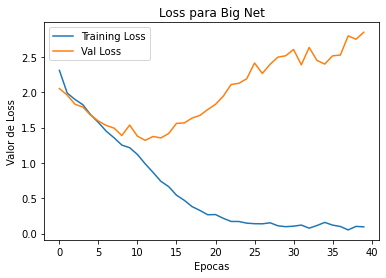

time: 172 ms


In [ ]:
plt.plot(Train_Loss_Total_BigN)
plt.plot(Val_Loss_Total_BigN)
plt.xlabel('Epocas')
plt.ylabel('Valor de Loss')
plt.title('Loss para Big Net')
plt.legend(['Training Loss', 'Val Loss'])
plt.show()

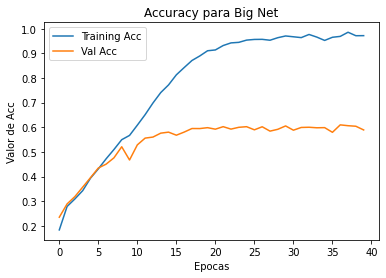

time: 156 ms


In [ ]:
plt.plot(Train_Acc_Total_BigN)
plt.plot(Val_Acc_Total_BigN)
plt.xlabel('Epocas')
plt.ylabel('Valor de Acc')
plt.title('Accuracy para Big Net')
plt.legend(['Training Acc', 'Val Acc'])
plt.show()

#### Prueba:

In [ ]:
# Test:
Test_Acc_BigN = 0
Cantidad_Aciertos_Test_BigN = 0
Lista_Predicted_BigN = torch.tensor([]).cuda()

with torch.no_grad():
  for i, data in enumerate(test_loader, 0):
    labels = data[0].cuda()
    inputs = data[1].float().cuda()
    outputs = net_BigN(inputs)
    _, Predicted_Test_BigN = torch.max(outputs, 1)
    Cantidad_Aciertos_Test_BigN += (Predicted_Test_BigN == labels).sum()
    Lista_Predicted_BigN = torch.cat((Predicted_Test_BigN,Lista_Predicted_BigN),dim=0)
Test_Acc_BigN = Cantidad_Aciertos_Test_BigN /  test_loader.__len__() / BatchSize

print(f'Accuracy del conjunto de prueba para BigNet: {Test_Acc_BigN*100:.4f}%')

Accuracy del conjunto de prueba para BigNet: 59.0400%
time: 3.19 s


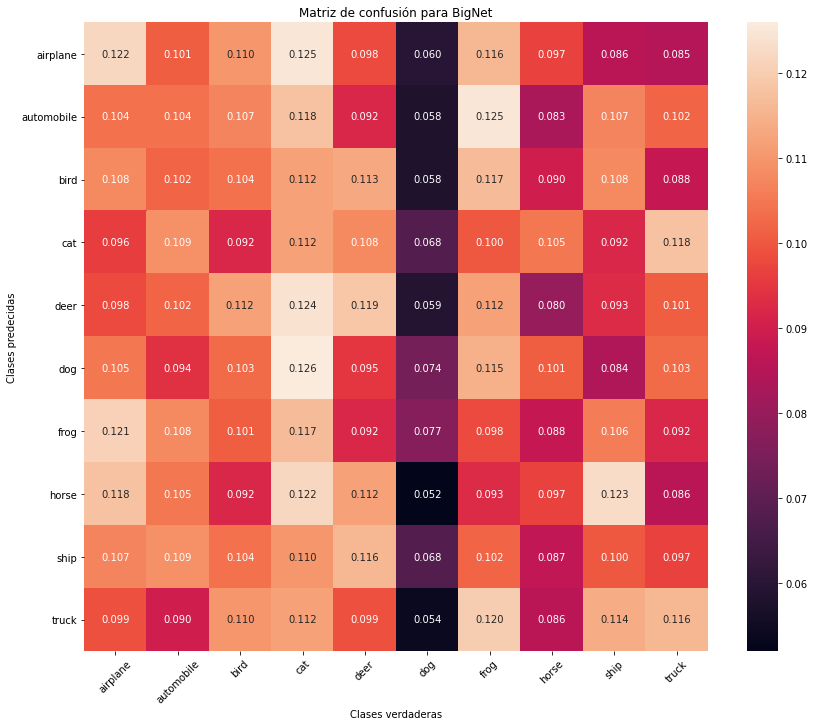

time: 692 ms


In [ ]:
Matriz_Cf_BigN = confusion_matrix(dataset_test.labels,Lista_Predicted_BigN.cpu())
Matriz_Cf_BigN = Matriz_Cf_BigN.astype('float') / Matriz_Cf_BigN.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(12,10))
sns.heatmap(Matriz_Cf_BigN,fmt= '0.3f', annot=True)
plt.title('Matriz de confusión para BigNet')
Ticks = np.arange(len(Labels[b'label_names'])) + 0.5
Labels_Decoded = [x.decode('utf-8') for x in Labels[b'label_names']]
plt.xticks(Ticks,Labels_Decoded,rotation = 45)
plt.yticks(Ticks,Labels_Decoded,rotation = 0)
plt.tight_layout()
plt.xlabel('Clases verdaderas')
plt.ylabel('Clases predecidas')
plt.show()

### Small Net:

#### Entrenamiento:

##### Código:

In [ ]:
net_SmallN = SmallNet(10)
net_SmallN.cuda()
criterion_SmallN = nn.CrossEntropyLoss()
optimizer_SmallN = torch.optim.Adam(net_SmallN.parameters(), lr=1e-3)

Train_Loss_Total_SmallN = []
Val_Loss_Total_SmallN = []
Train_Acc_Total_SmallN = []
Val_Acc_Total_SmallN = []

for epoch in range(40):
  # Train:
  Train_Loss_SmallN = 0
  Train_Acc_SmallN = 0
  Cantidad_Aciertos_SmallN = 0
  net_SmallN.train()
  for i, data in enumerate(train_loader, 0): # Obtener batch
    labels = data[0].cuda()
    inputs = data[1].float().cuda()
    optimizer_SmallN.zero_grad()
    outputs = net_SmallN(inputs)
    _, Predicted_Tr_SmallN = torch.max(outputs, 1)
    loss = criterion_SmallN(outputs, labels)
    loss.backward()
    optimizer_SmallN.step()
    Train_Loss_SmallN += loss.item() / len(train_loader)
    Cantidad_Aciertos_SmallN += (Predicted_Tr_SmallN == labels).sum().item()
  Train_Acc_SmallN = Cantidad_Aciertos_SmallN / train_loader.__len__() / BatchSize

  # Validation:
  Val_Loss_SmallN = 0
  Val_Acc_SmallN = 0
  Cantidad_Aciertos_2_SmallN = 0
  net_SmallN.eval()
  with torch.no_grad():
    for i, data in enumerate(val_loader, 0):
      labels = data[0].cuda()
      inputs = data[1].float().cuda()
      optimizer_SmallN.zero_grad()
      outputs = net_SmallN(inputs)
      _, Predicted_Val_SmallN = torch.max(outputs, 1)
      loss = criterion_SmallN(outputs, labels)
      Val_Loss_SmallN += loss.item() / len(val_loader)
      Cantidad_Aciertos_2_SmallN += (Predicted_Val_SmallN == labels).sum().item()
  Val_Acc_SmallN = Cantidad_Aciertos_2_SmallN /  val_loader.__len__() / BatchSize

  # Guardado de valores:
  Train_Loss_Total_SmallN.append(Train_Loss_SmallN)
  Val_Loss_Total_SmallN.append(Val_Loss_SmallN)
  Train_Acc_Total_SmallN.append(Train_Acc_SmallN)
  Val_Acc_Total_SmallN.append(Val_Acc_SmallN)

time: 5min 5s


##### Gráficos

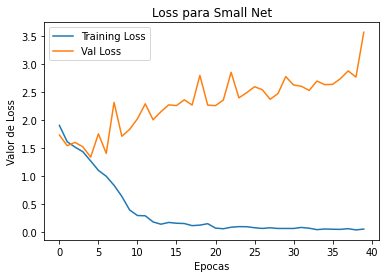

time: 148 ms


In [ ]:
plt.plot(Train_Loss_Total_SmallN)
plt.plot(Val_Loss_Total_SmallN)
plt.xlabel('Epocas')
plt.ylabel('Valor de Loss')
plt.title('Loss para Small Net')
plt.legend(['Training Loss', 'Val Loss'])
plt.show()

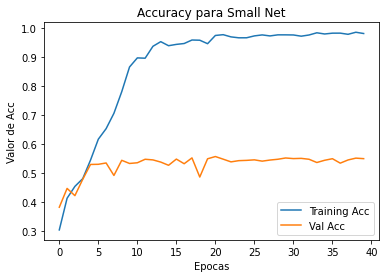

time: 150 ms


In [ ]:
plt.plot(Train_Acc_Total_SmallN)
plt.plot(Val_Acc_Total_SmallN)
plt.xlabel('Epocas')
plt.ylabel('Valor de Acc')
plt.title('Accuracy para Small Net')
plt.legend(['Training Acc', 'Val Acc'])
plt.show()

#### Prueba:

In [ ]:
# Test:
Test_Acc_SmallN = 0
Cantidad_Aciertos_Test_SmallN = 0
Lista_Predicted_SmallN = torch.tensor([]).cuda()
net_SmallN.eval()
with torch.no_grad():
  for i, data in enumerate(test_loader, 0):
    labels = data[0].cuda()
    inputs = data[1].float().cuda()
    optimizer_SmallN.zero_grad()
    outputs = net_SmallN(inputs)
    _, Predicted_Test_SmallN = torch.max(outputs, 1)
    Cantidad_Aciertos_Test_SmallN += (Predicted_Test_SmallN == labels).sum().item()
    Lista_Predicted_SmallN = torch.cat((Predicted_Test_SmallN,Lista_Predicted_SmallN),dim=0)
Test_Acc_SmallN = Cantidad_Aciertos_Test_SmallN /  test_loader.__len__() / BatchSize

# Accuracy del conjunto de prueba:

print(f'Accuracy del conjunto de prueba para SmallNet: {Test_Acc_SmallN*100:.4f}%')

Accuracy del conjunto de prueba para SmallNet: 55.3100%
time: 2.49 s


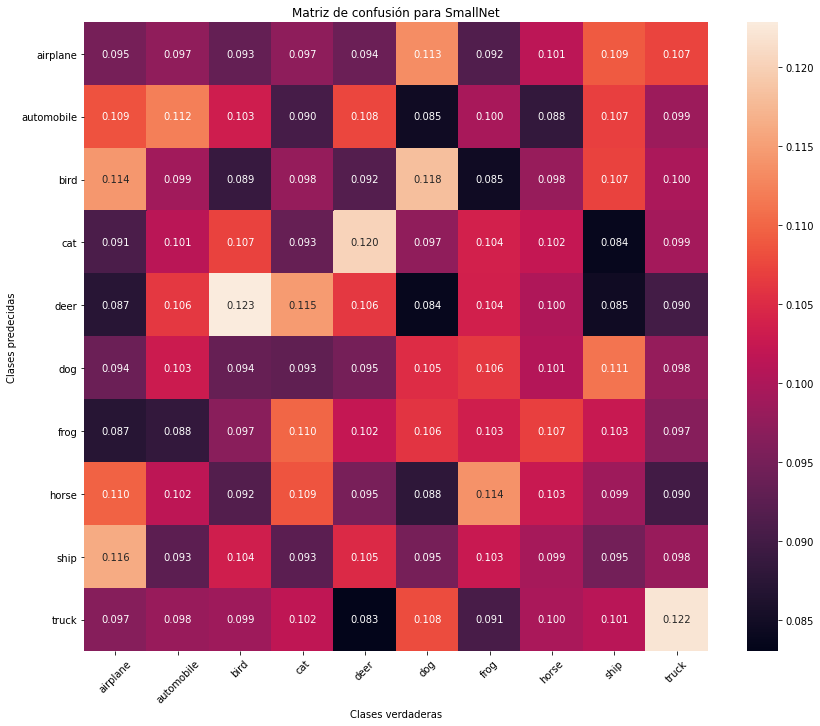

time: 677 ms


In [ ]:
Matriz_Cf_SmallN = confusion_matrix(dataset_test.labels,Lista_Predicted_SmallN.cpu(), normalize = 'pred')
Matriz_Cf_SmallN = Matriz_Cf_SmallN.astype('float') / Matriz_Cf_SmallN.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(12,10))
sns.heatmap(Matriz_Cf_SmallN,fmt= '0.3f', annot=True)
plt.title('Matriz de confusión para SmallNet')
Ticks = np.arange(len(Labels[b'label_names'])) + 0.5
Labels_Decoded = [x.decode('utf-8') for x in Labels[b'label_names']]
plt.xticks(Ticks,Labels_Decoded,rotation = 45)
plt.yticks(Ticks,Labels_Decoded,rotation = 0)
plt.tight_layout()
plt.xlabel('Clases verdaderas')
plt.ylabel('Clases predecidas')
plt.show()

# Análisis de resultados

En ambas redes se puede observar que ocurre un sobreajuste respecto a los datos de entrenamiento, lo cual viene dado por el aumento de la Loss de Validación a medida que transcurren las épocas, en conjunto con el estancamiento de la Accuracy de Validación al transcurrir entre 5 a 10 épocas.

Se puede observar que, debido a la mayor complejidad de la Big Net con respecto a la Small Net, el tiempo de ejecución es mayor para la primera que para la segunda; sin embargo, la precisión es ligeramente mayor para la primera.

Ambas matrices de confusión no entregan resultados pertinentes, siendo la clasificación no adecuada para las clases.

Considerando lo presentado en los resultados mencionados, se concluye que la arquitectura con mejor desempeño consiste en la **Small Net**, con una velocidad de convergencia respecto al conjunto de validación de 8 épocas, una Accuracy para el conjunto de validación de aproximadamente 55%, y una accuracy para el conjunto de prueba de 50%.

# Conclusiones



In [ ]:
%%shell
jupyter nbconvert --to html /content/Tarea_5_EL7008.ipynb

[NbConvertApp] WARNING | pattern u'/content/Tarea_5_EL7008.ipynb' matched no files
This application is used to convert notebook files (*.ipynb) to various other
formats.


Options
-------

Arguments that take values are actually convenience aliases to full
Configurables, whose aliases are listed on the help line. For more information
on full configurables, see '--help-all'.

--execute
    Execute the notebook prior to export.
--allow-errors
    Continue notebook execution even if one of the cells throws an error and include the error message in the cell output (the default behaviour is to abort conversion). This flag is only relevant if '--execute' was specified, too.
--no-input
    Exclude input cells and output prompts from converted document. 
    This mode is ideal for generating code-free reports.
--stdout
    Write notebook output to stdout instead of files.
--stdin
    read a single notebook file from stdin. Write the resulting notebook with default basename 'notebook.*'
--inpla

CalledProcessError: ignored

time: 619 ms
